In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
import anndata as ad
import itertools
#import alphashape
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Prepare data

In [2]:
jem_rna = ad.read_h5ad('data/JEM_GEX.h5ad')
jem_atac = ad.read_h5ad('data/scATAC/JEM_ATAC.peaks.h5ad')
jem_atac_act = ad.read_h5ad('data/JEM_ATAC.h5ad')


In [3]:
jem_atac = jem_atac[jem_atac_act.obs_names]
jem_atac.obs['cell_type'] = jem_atac_act.obs['cell_type'].copy()
jem_atac.obs['current_severity_bin'] = jem_atac_act.obs['current_severity_bin'].copy()

jem_rna.X = jem_rna.layers['matrix'].copy()


Trying to set attribute `.obs` of view, copying.


In [4]:
jem_rna.X.max()

1244.0

In [5]:
merge = pd.read_csv('SiaNN_embed_PBMCmodel.txt')
out_x = merge.iloc[0:jem_rna.n_obs,1:].to_numpy().astype('float32')
out_x = out_x.copy(order='C')
out_y = merge.iloc[jem_rna.n_obs:,1:].to_numpy().astype('float32')
out_y = out_y.copy(order='C')


In [6]:
jem_rna.obsm['SiaNN'] = out_x
jem_atac.obsm['SiaNN'] = out_y

#### Smoothing

In [7]:
num_neigh = 5

In [9]:
#rna = sc.read_h5ad("10XMultiome_GEX.PBMC.h5ad")
rna_siaNN = jem_rna.copy()
rna_siaNN.obsm['X_pca'] = rna_siaNN.obsm['SiaNN']
sc.pp.neighbors(rna_siaNN, n_neighbors=num_neigh)
x = np.ravel(rna_siaNN.obsp['distances'].toarray())
x = x[x > 0]
t = np.percentile(x, 95)

d1 = rna_siaNN.obsp['distances']
d1[d1 > t] = 0

c1 = rna_siaNN.obsp['connectivities']
c1[d1 > t] = 0

c1[c1 > 0] = 1 # no weighted
c1.setdiag(1)

rna_siaNN.obsp['connectivity'] = c1
rna_siaNN.obsp['distances'] = d1

rna_siaNN.layers['smoothed_counts'] = c1 * rna_siaNN.layers['matrix']

rna_siaNN.layers['original_log1p'] = rna_siaNN.X.copy()
rna_siaNN.layers['original_counts'] = jem_rna.layers['matrix'].copy()
rna_siaNN.X = rna_siaNN.layers['smoothed_counts'].copy()

In [10]:
rna_siaNN.write_h5ad('data/JEM_GEX.smoothed.%sNN.h5ad'%(num_neigh))

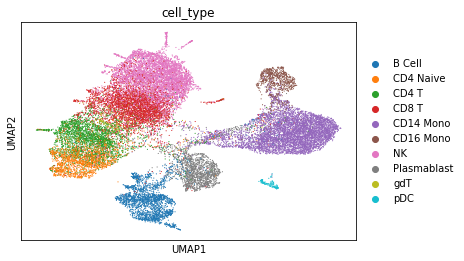

In [11]:
sc.pp.normalize_total(rna_siaNN)
sc.pp.log1p(rna_siaNN)
sc.pp.pca(rna_siaNN)
sc.pp.neighbors(rna_siaNN, n_neighbors=10)
sc.tl.umap(rna_siaNN)
sc.pl.umap(rna_siaNN, color=['cell_type'])

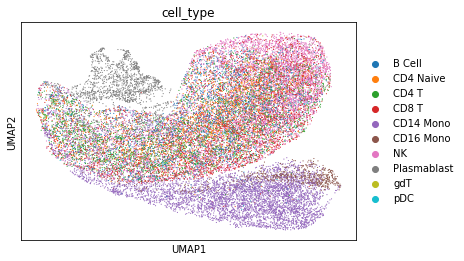

In [13]:
sc.pp.pca(jem_rna, n_comps=30)
sc.pp.neighbors(jem_rna, n_neighbors=10)
sc.tl.umap(jem_rna)
sc.pl.umap(jem_rna, color=['cell_type'])

In [16]:
atac_siaNN = jem_atac.copy()
atac_siaNN.obsm['X_pca'] = atac_siaNN.obsm['SiaNN']

sc.pp.neighbors(atac_siaNN, n_neighbors=num_neigh)
x = np.ravel(atac_siaNN.obsp['distances'].toarray())
x = x[x > 0]
t = np.percentile(x, 95)

d1 = atac_siaNN.obsp['distances']
d1[d1 > t] = 0

c1 = atac_siaNN.obsp['connectivities']
c1[d1 > t] = 0

c1[c1 > 0] = 1 # no weighted
c1.setdiag(1)

atac_siaNN.obsp['connectivity'] = c1
atac_siaNN.obsp['distances'] = d1

smooth_atac_counts = c1 * atac_siaNN.X

smooth_atac_bins = smooth_atac_counts.copy()

smooth_atac_bins[smooth_atac_counts > 0] = 1

atac_siaNN.layers['smoothed_counts'] = smooth_atac_counts
atac_siaNN.layers['original_counts'] = atac_siaNN.X.copy()

atac_siaNN.X = smooth_atac_bins


In [17]:
atac_siaNN.write_h5ad('data/JEM_ATAC.smoothed.%sNN.h5ad'%(num_neigh))

In [18]:
print(np.sum(jem_atac.X > 0) / np.product(jem_atac.shape)), print(np.sum(atac_siaNN.X > 0) / np.product(jem_atac.shape))


0.03685233109632764
0.22041138113254935


(None, None)